


## Instal libraries & loading data  







In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



###this is dataset from kaggle

**https://www.kaggle.com/datasets/aymanaalqrabawi/cancer-brain-dataset**

In [47]:
train_path = '/content/drive/MyDrive/Training'
test_path = '/content/drive/MyDrive/Testing'

In [3]:


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix




In [4]:

'''
access data from google drive directly from colab
and named it as train_path and test_path
then store them in a list and label them in a list too

'''
train_paths=[]
train_label=[]
test_paths=[]
test_lebel=[]

for label in os.listdir(train_path):
  for image in os.listdir(train_path + '/' + label):
    train_paths.append(train_path + '/' + label + '/' + image)
    train_label.append(label)


for label in os.listdir(test_path):
  for image in os.listdir(test_path + '/' + label):
    test_paths.append(test_path + '/' + label + '/' + image)
    test_lebel.append(label)

## Visualization some imges

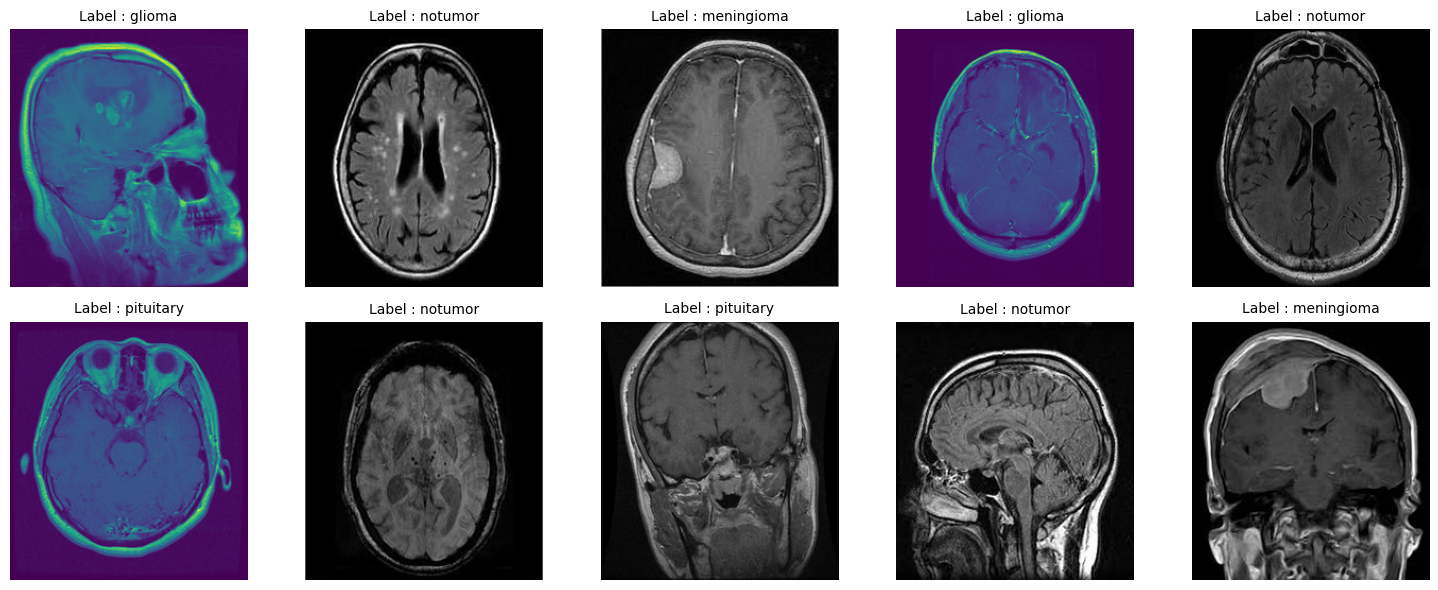

In [8]:
'''
 visualized some images from data set

'''


random_idx = random.sample(range(len(train_paths)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.flatten()

for i, idx in enumerate(random_idx):
    img = Image.open(train_paths[idx])
    img = img.resize((224,244))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Label : {train_label[idx]}',fontsize=10)

plt.tight_layout()
plt.show()

## Normalized & Augmented Data

All images in both the training and testing datasets were **normalized** by rescaling pixel values to the range \([0,1]\). This normalization improves numerical stability, accelerates convergence, and ensures a consistent input distribution across the neural network.

To further enhance training stability and gradient flow, **Batch Normalization** layers are inherently utilized within the ResNet architecture, reducing internal covariate shift and enabling deeper networks to train effectively.

Additionally, **data augmentation** techniques such as rotation, width and height shifting, zooming, and horizontal flipping were applied **only to the training data**. This helps mitigate overfitting and high variance, thereby improving the model’s generalization performance.

The **batch size** was set to 32, resulting in:
- ⌈5712 / 32⌉ = **179 steps per training epoch**
- ⌈1311 / 32⌉ = **41 steps per validation/testing epoch**

The **class mode** was configured as *categorical* to support multi-class classification.  
The **input image size** was fixed at *(224 × 224)*, as required by the ResNet architecture employed in this project.




In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)



Found 5712 images belonging to 4 classes.


In [15]:
print(train_generator.samples)
print(train_generator.class_indices.items())


5712
dict_items([('glioma', 0), ('meningioma', 1), ('notumor', 2), ('pituitary', 3)])


In [18]:
test_datagen = ImageDataGenerator(
    rescale=1./255.
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),

    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


In [20]:
print(test_generator.samples)
print(test_generator.class_indices.items())


1311
dict_items([('glioma', 0), ('meningioma', 1), ('notumor', 2), ('pituitary', 3)])


## Model

The model is built using the **ResNet (Residual Network)** architecture, which introduces **identity (skip) connections** that allow the input of a layer to be directly added to its output. These residual connections enable the network to learn residual mappings instead of direct mappings, making optimization significantly easier for deep architectures.

Identity connections play a critical role in **preserving gradient flow during backpropagation**, effectively mitigating the **vanishing gradient problem**. As a result, ResNet can be trained with a large number of layers while maintaining stable and efficient learning, leading to stronger and more discriminative feature representations.

To adapt the convolutional feature maps produced by ResNet to the classification head, **Global Average Pooling (GAP)** is used instead of a Flatten layer. Global Average Pooling reduces each feature map to a single representative value, which:
- Significantly reduces the number of trainable parameters  
- Lowers the risk of overfitting  
- Preserves spatially aggregated semantic information  
This design choice is particularly effective in deep CNN architectures such as ResNet and is commonly recommended in transfer learning setups.

In addition, **transfer learning** is employed by initializing the network with **ImageNet pre-trained weights**. This allows the model to leverage low-level and mid-level visual features (such as edges, textures, and shapes) learned from large-scale natural image datasets, which:
- Accelerates convergence during training  
- Reduces the need for large labeled medical datasets  
- Improves generalization performance and robustness  

Finally, **fine-tuning** is applied by unfreezing the last few layers of the ResNet backbone, enabling the model to adapt high-level features to the **medical image domain** and improve discrimination between different brain tumor classes.



In [21]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(train_generator.num_classes, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,821,316 (94.69 MB)

 Trainable params: 5,693,380 (21.72 MB)

 Non-trainable params: 19,127,936 (72.97 MB)

In [23]:
history = model.fit(
    train_generator,
    epochs=6,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1779s 10s/step - accuracy: 0.2620 - loss: 2.0084
Epoch 2/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1567s 8s/step - accuracy: 0.3633 - loss: 1.6459
Epoch 3/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1446s 8s/step - accuracy: 0.4160 - loss: 1.5037
Epoch 4/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1441s 8s/step - accuracy: 0.4380 - loss: 1.4393
Epoch 5/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1423s 8s/step - accuracy: 0.4825 - loss: 1.3476
Epoch 6/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1397s 8s/step - accuracy: 0.4969 - loss: 1.3048


In [24]:
test_predics = model.predict(test_generator)


41/41 ━━━━━━━━━━━━━━━━━━━━ 370s 9s/step


In [25]:
y_true = test_generator.classes
y_pred = np.argmax(test_predics, axis=1)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.47      0.55       300
           1       0.52      0.38      0.44       306
           2       0.73      0.80      0.77       405
           3       0.64      0.92      0.76       300

    accuracy                           0.65      1311
   macro avg       0.64      0.64      0.63      1311
weighted avg       0.64      0.65      0.64      1311



In [26]:
model.save('brain cancer.h5')

[[141  87  14  58]
 [ 34 116  95  61]
 [ 36  11 325  33]
 [  5  11   9 275]]


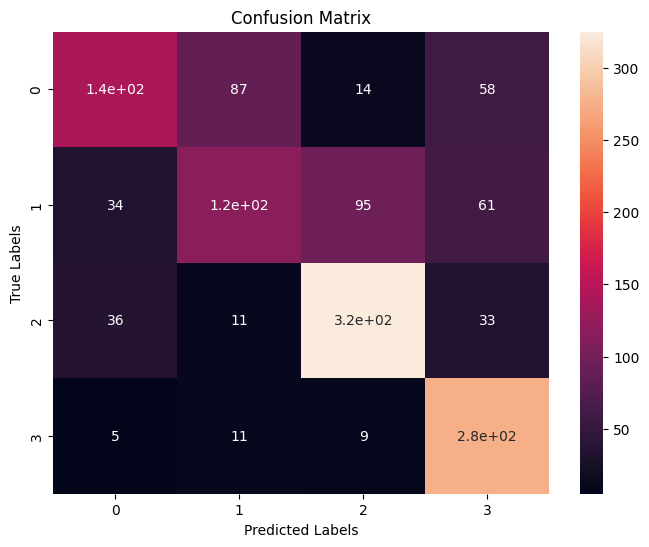

In [29]:
import seaborn as sns
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Files in folder: ['Te-glTr_0004.jpg', 'Te-gl_0010.jpg', 'Te-glTr_0001.jpg', 'Te-glTr_0008.jpg', 'Te-gl_0011.jpg', 'Te-glTr_0007.jpg', 'Te-glTr_0005.jpg', 'Te-glTr_0003.jpg', 'Te-gl_0012.jpg', 'Te-glTr_0000.jpg', 'Te-glTr_0002.jpg', 'Te-glTr_0006.jpg', 'Te-glTr_0009.jpg', 'Te-gl_0022.jpg', 'Te-gl_0069.jpg', 'Te-gl_0055.jpg', 'Te-gl_0052.jpg', 'Te-gl_0031.jpg', 'Te-gl_0057.jpg', 'Te-gl_0021.jpg', 'Te-gl_0065.jpg', 'Te-gl_0046.jpg', 'Te-gl_0050.jpg', 'Te-gl_0036.jpg', 'Te-gl_0042.jpg', 'Te-gl_0062.jpg', 'Te-gl_0016.jpg', 'Te-gl_0076.jpg', 'Te-gl_0027.jpg', 'Te-gl_0075.jpg', 'Te-gl_0034.jpg', 'Te-gl_0060.jpg', 'Te-gl_0024.jpg', 'Te-gl_0023.jpg', 'Te-gl_0040.jpg', 'Te-gl_0048.jpg', 'Te-gl_0071.jpg', 'Te-gl_0013.jpg', 'Te-gl_0067.jpg', 'Te-gl_0045.jpg', 'Te-gl_0043.jpg', 'Te-gl_0033.jpg', 'Te-gl_0037.jpg', 'Te-gl_0053.jpg', 'Te-gl_0066.jpg', 'Te-gl_0047.jpg', 'Te-gl_0073.jpg', 'Te-gl_0054.jpg', 'Te-gl_0014.jpg', 'Te-gl_0059.jpg', 'Te-gl_0032.jpg', 'Te-gl_0035.jpg', 'Te-gl_0077.jpg', 'Te-gl_0

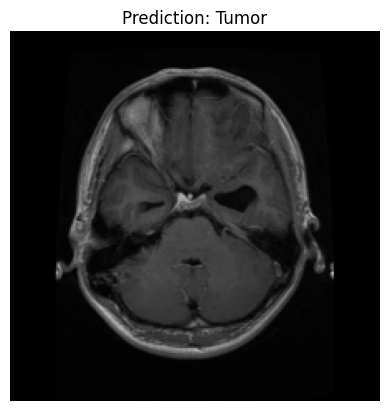

In [60]:
'''
this is test data you use any data from any source

 Building these models doesn't stop at simply building a model and that's it!
 It can significantly reduce the time doctors spend on diagnosis,
 so I made sure the model was robust
 and adaptable for my colleagues to improve upon if they wished.

author : ayman alaqrabawi
date : 9/2/2026



'''

from keras.utils import load_img, img_to_array
import numpy as np

folder_path = '/content/drive/MyDrive/Testing/glioma/'
print("Files in folder:", os.listdir(folder_path))

img_name = os.listdir(folder_path)[0]
img_path = os.path.join(folder_path, img_name)

img = load_img(img_path)
img = img.resize((224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
prediction = model.predict(img_array)

label = "Benign" if prediction[0][0] < 0.5 else "Tumor"
print("Predicted label:", label)
print("Prediction probability:", prediction[0][0])

#
plt.imshow(img)
plt.title(f"Prediction: {label}")
plt.axis('off')
plt.show()
